# Grain Price Simulator
Adjust inflation, amplitudes, volatility, and seed.

In [24]:
"""
Grain price simulator with inflation drift, two-peaks-per-year seasonality,
and geometric noise, and optional high-frequency jitter for extra "hairiness". 
Includes CLI for quick CSV export and plotting.

Usage (CLI examples):
  python grain_simulator.py --start-price 220 --years 3 --inflation 0.05 \
    --season-twice 0.10 --north-bias 0.04 --jitter 0.01 --vol 0.08 --seed 7 \
    --csv "grain_prices.csv" --plot

Author: ChatGPT
"""
from __future__ import annotations

import argparse
import math
from dataclasses import dataclass
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


@dataclass
class GrainSimParams:
    start_price: float = 220.0
    years: int = 3
    inflation_annual: float = 0.05
    season_peak_twice_amp: float = 0.10  # amplitude of 2-peaks-per-year component
    north_bias_amp: float = 0.04         # small annual asymmetry (north harvest stronger)
    volatility_annual: float = 0.08
    jitter_amp: float = 0.0 
    seed: Optional[int] = 7


def simulate_grain_prices(params: GrainSimParams) -> pd.DataFrame:
    """
    Simulate daily grain prices over `params.years` years.
    Components:
      - Inflation drift (exponential): inflation_annual
      - Seasonality: two peaks per year via cos(2*omega*t) + small annual bias via cos(omega*t)
      - Geometric (GBM-like) noise with annualized volatility
    
    Returns:
      DataFrame indexed by daily dates with column 'Price' (float).
    """
    rng = np.random.default_rng(params.seed)
    days = int(365 * params.years)
    t = np.arange(days, dtype=float)

    # Daily drift/vol
    drift_daily = math.log(1.0 + params.inflation_annual) / 365.0
    vol_daily = params.volatility_annual / math.sqrt(365.0)

    # Seasonality
    omega = 2.0 * math.pi / 365.0
    season_twice = params.season_peak_twice_amp * np.cos(2.0 * omega * t)  # two peaks per year
    season_bias  = params.north_bias_amp * np.cos(omega * t)               # small asymmetry
    seasonal = 1.0 + season_twice + season_bias

    # GBM-style trend
    noise = rng.normal(0.0, 1.0, size=days)
    log_returns = drift_daily + vol_daily * noise
    trend = np.exp(np.cumsum(log_returns))

    prices = params.start_price * trend * seasonal

    # Add high-frequency jitter
    if params.jitter_amp > 0:
        jitter = 1.0 + params.jitter_amp * rng.normal(0.0, 1.0, size=days)
        prices *= jitter

    start_date = pd.Timestamp.today().normalize()
    dates = pd.date_range(start=start_date, periods=days, freq="D")
    return pd.DataFrame({"Price": prices}, index=dates)


def plot_prices(df: pd.DataFrame, title: str = "Grain Price Simulation"):
    """Plot the simulated price series and draw blue vertical lines each year."""
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df["Price"])
    ax = plt.gca()

    # Draw blue vertical lines after each year (every 365 days)
    start = df.index[0]
    n_years = int(len(df) / 365)
    for i in range(1, n_years + 1):
        x = start + pd.Timedelta(days=365 * i)
        if x <= df.index[-1]:
            ax.axvline(x=x, color="blue", linestyle="--", linewidth=1, alpha=0.8)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


def main():
    parser = argparse.ArgumentParser(description="Grain price simulator")
    parser.add_argument("--start-price", type=float, default=220.0)
    parser.add_argument("--years", type=int, default=3)
    parser.add_argument("--inflation", type=float, default=0.05, help="Annual inflation (e.g., 0.05 = 5%)")
    parser.add_argument("--season-twice", type=float, default=0.10, help="Amplitude of 2-peaks-per-year component")
    parser.add_argument("--north-bias", type=float, default=0.04, help="Amplitude of annual bias (north stronger)")
    parser.add_argument("--vol", type=float, default=0.08, help="Annualized volatility")
    parser.add_argument("--jitter", type=float, default=0.0, help="Amplitude of extra daily jitter")
    parser.add_argument("--seed", type=int, default=7)
    parser.add_argument("--csv", type=str, default=None, help="Path to save CSV")
    parser.add_argument("--plot", action="store_true", help="Show a matplotlib line chart")
    args = parser.parse_args()

    params = GrainSimParams(
        start_price=args.start_price,
        years=args.years,
        inflation_annual=args.inflation,
        season_peak_twice_amp=args.season_twice,
        north_bias_amp=args.north_bias,
        volatility_annual=args.vol,
        jitter_amp=args.jitter,
        seed=args.seed,
    )
    df = simulate_grain_prices(params)

    if args.csv:
        df.to_csv(args.csv, index_label="Date")
        print(f"Saved CSV to {args.csv}")

    if args.plot:
        title = f"Grain Price Simulation — {params.years}y, infl {params.inflation_annual:.1%}, vol {params.volatility_annual:.1%}"
        plot_prices(df, title=title)

# Functions/classes loaded.

**`jitter`** má jednotky jako relativní amplituda, tedy „kolik procent“ může každý den náhodně kolísat *navíc* kolem základní ceny.

Doporučené rozsahy:

| Charakter grafu         | Doporučený jitter_amp | Popis                                    |
| ----------------------- | --------------------- | ---------------------------------------- |
| žádný dodatečný šum     | `0.0`                 | hladký graf (jen sezónnost + volatilita) |
| mírně chlupatý          | `0.002 – 0.005`       | jemné denní zuby, skoro neznatelné       |
| přirozeně šumivý        | `0.005 – 0.01`        | realistický drobný „denní ruch“          |
| výrazně chlupatý        | `0.01 – 0.02`         | viditelně rozcuchaný, „živý“ trh         |
| extrémní, skoro náhodný | `> 0.03`              | spíš testovací, velmi rozptýlené ceny    |

Technicky:

* `0.01` znamená ±1 % náhodný denní mikro-výkyv kolem ceny.
* Hodnota se násobí náhodou `N(0,1)`, takže i malá hodnota dává patrný efekt.
* V kombinaci s `--vol` (např. 0.05–0.08) to vypadá realisticky, když `--jitter` držíš mezi `0.005–0.015`.

💡 **Tip:**
Zkus např.

```
--vol 0.06 --jitter 0.008
```

nebo

```
--vol 0.10 --jitter 0.012
```

→ první bude klidnější, druhý „živější“ a s více denním šumem.


## Example usage

In [25]:
params = GrainSimParams(start_price=220.0, years=3,
                        inflation_annual=0.05,
                        season_peak_twice_amp=0.10,
                        north_bias_amp=0.04,
                        volatility_annual=0.08,
                        jitter_amp=0.008,
                        seed=7)
df = simulate_grain_prices(params)
df.head()

,Price
2025-11-02,251.535263
2025-11-03,249.801159
2025-11-04,254.964350
2025-11-05,254.515035
2025-11-06,246.439490


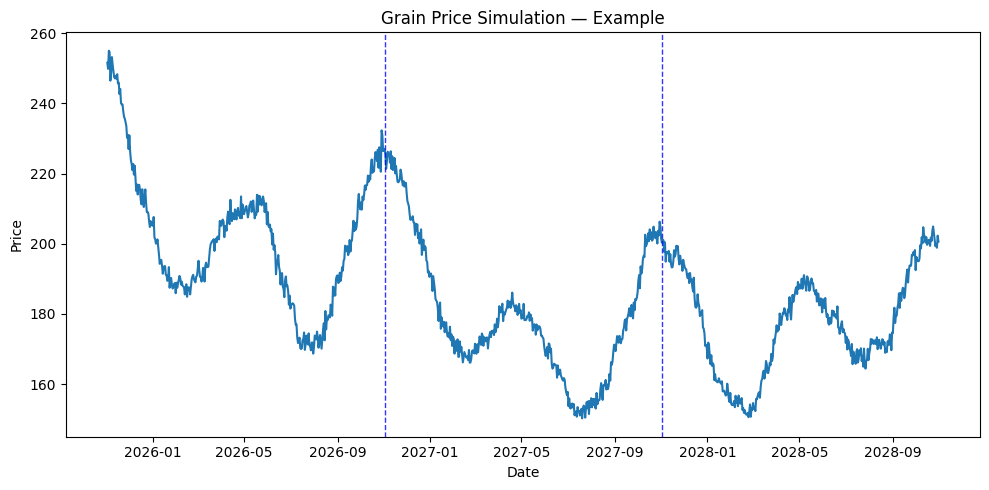

In [26]:
plot_prices(df, title='Grain Price Simulation — Example')

## Doporučené kombinace (zkopíruj do CLI / notebooku):

### Mírné, klidné výkyvy (malé sezóny, málo šumu):
```
--season-twice 0.02 --north-bias 0.005 --vol 0.03 --inflation 0.05 --seed 11
```

### Menší „makro“ výkyvy, ale lehká chlupatost:
```
--season-twice 0.03 --north-bias 0.008 --vol 0.06 --inflation 0.05 --seed 21
```

### Výraznější chlupatost bez velkých trendových odchylek:
```
--season-twice 0.02 --north-bias 0.003 --vol 0.10 --inflation 0.05 --seed 33
```

(malé sezónní vlny, ale jemné denní zuby díky vyšší volatilitě)

### Vyvážené (střední chlupatost, střední sezóna):
```
--season-twice 0.05 --north-bias 0.015 --vol 0.08 --inflation 0.05 --seed 7
```

## Tipy:

- Volatilita (--vol) = kolik šumu má každý den. Vyšší → víc „chlupaté“, ale i potenciálně větší odchylky. Omez to nižšími amplitudami sezóny (--season-twice, --north-bias), aby makro-vlna nebyla moc velká.

- Seed měň, když chceš jinou „texturu“ křivky při stejných parametrech (např. --seed 1, --seed 2, …).

- Inflaci nech klidně na 0.05; nemá velký vliv na chlupatost, spíš na dlouhodobý sklon.

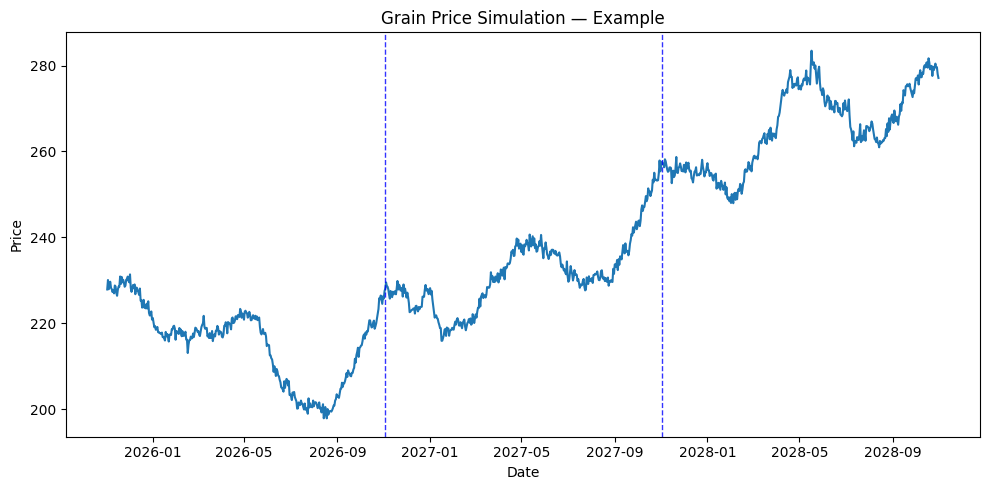

In [27]:
# --season-twice 0.03 --north-bias 0.008 --vol 0.06 --inflation 0.05 --seed 21

params = GrainSimParams(start_price=220.0, years=3,
                         inflation_annual=0.025,
                         season_peak_twice_amp=0.03,
                         north_bias_amp=0.008,
                         volatility_annual=0.06,
                         jitter_amp=0.003,
                         seed=21)
df = simulate_grain_prices(params)

plot_prices(df, title='Grain Price Simulation — Example')